# Imputing

Let's impute the missingness away!

In this Notebook we will have a look at various imputation methods and compare their results and performances.
Compared imputation methods:
 + LOCF (last observed carried forward)
 + NOCB (next observation carried backward)
 + Mean imputation
 + Median imputation
 + BRITS (Single imputation)
 + SAITS (Single imputation)
 + mTAN (Multiple imputation)


In [98]:
%load_ext autoreload
%autoreload 2


from mTAN import *
from toy_dataset import data_utils
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Dataset

Here we create mcar missingness.


In [157]:
name = 'toydataset_small'
path = data_utils.datasets_dict[name]['path']
dataset = data_utils.ToyDataDf(path)

error_dict = dict()
missingness = np.linspace(0.1,0.9,9)

# Simple Imputations

+ LOCF
+ NOCB
+ Mean
+ Median

### Mean Imputation

The dataset is a collection of many individual time series, which can potentially have different lengths. Missing values are filled with the mean of the *corresponding time series*.

In [169]:
mean_error = list()
for m in missingness:
    dataset.create_mcar_missingness(m, verbose=False)
    mean = dataset.impute_mean()
    mse = dataset.mse(mean)
    mean_error.append(mse)

error_dict['mean'] = mean_error
print('Done.')

Done.


### Median Imputation

Same as for Mean Imputation, the mean is calculated for each time series.

In [168]:
median_error = list()
for m in missingness:
    dataset.create_mcar_missingness(m, verbose=False)
    median = dataset.impute_median()
    mse = dataset.mse(median)
    median_error.append(mse)

error_dict['median'] = median_error
print('Done.')

Done.


# Visualize results


mean
median


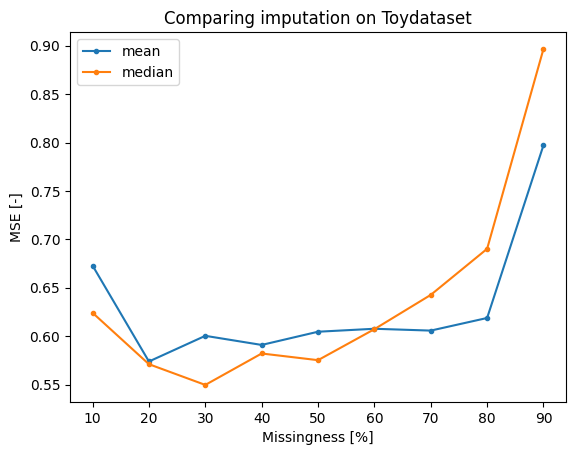

In [170]:
fig = plt.figure()
plt.title(f'Comparing imputation on {dataset.name}')
plt.ylabel('MSE [-]')
plt.xlabel('Missingness [%]')
for key in error_dict.keys():
    print(key)
    plt.plot(missingness*100, error_dict[key], marker='o', ms=3, label=key)
plt.legend()
